# plotting functions of figure 2 in the manuscript
Overview plot of the first section. In the plot we show the result of reconstructing synthetic data simulated with Roodmus into a consensus (homogeneous) density map. 


In [1]:
# imports
import os
import re
import mrcfile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# added following for 1to1 match prototyping
from tqdm import tqdm
from typing import Any
from collections.abc import KeysView as dict_keys

from gemmi import cif

# roodmus
from roodmus.analysis.utils import load_data
from roodmus.analysis.plot_picking import (
    plot_precision, plot_recall, 
)


In [2]:
# functions
def get_resolution_from_logs(project_dir, data, verbose=False):
    results ={
        "Nparticles": [],
        "res_unmasked": [],
        "res": [],
    }
    
    # load the logfiles and retrieve the resolutions
    for _, item in data.items():
        if verbose:
            print(f"Processing {item['PostProcess']}")
        Refine3D_log = os.path.join(project_dir, "Refine3D", item["Refine3D"], "run.out")
        pattern = r"Auto-refine: \+ Final resolution \(without masking\) is: (\d+(\.\d+)?)"
        with open(Refine3D_log, "r") as f:
            for line in f.readlines():
                if re.search(pattern, line):
                    res_unmasked = float(re.search(pattern, line).group(1))
                    break

        PostProcess_log = os.path.join(project_dir, "PostProcess", item["PostProcess"], "run.out")
        pattern = r"\+\s*FINAL\s+RESOLUTION:\s+(\d+(\.\d+)?)"
        with open(PostProcess_log, "r") as f:
            for line in f.readlines():
                if re.search(pattern, line):
                    res = float(re.search(pattern, line).group(1))
                    break
        
        if verbose:
            print(f"Nparticles: {item['Nparticles']}")
            print(f"res_unmasked: {res_unmasked}")
            print(f"res: {res}")
        results["Nparticles"].append(item["Nparticles"])
        results["res_unmasked"].append(res_unmasked)
        results["res"].append(res)

    return results


## panel A
plot of the 2D classes generated during processing of the homogeneous (single-conformation) data. The 2D classification used here was done after the final reconstruction, for visualisation only and on the full-sized images (320x320).
plot of the FSC curve from RELION.

saved figure to: /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation/figures/class_averages.pdf


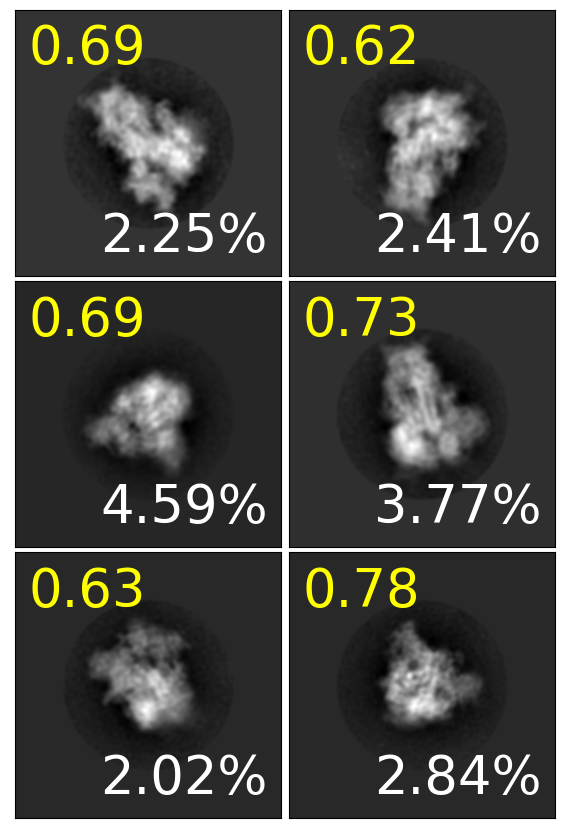

In [3]:
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation"
figures_dir = os.path.join(project_dir, "figures")
class_averages = os.path.join(project_dir, "Class2D", "job042", "run_it025_classes.mrcs")
ranker_output_file = os.path.join(project_dir, "Select", "job043", "class_averages.star")

num_rows = 3
num_columns = 2


class_averages_mrc = mrcfile.open(class_averages, mode='r')
class_ranker_cif = cif.read_file(ranker_output_file)
class_ranker_results = class_ranker_cif.sole_block()
rlnReferenceImage = class_ranker_results.find_loop('_rlnReferenceImage')
rlnPredictedClassScore = class_ranker_results.find_loop('_rlnPredictedClassScore')
rlnClassDistribution = class_ranker_results.find_loop('_rlnClassDistribution')
df = pd.DataFrame(data=[rlnReferenceImage, rlnPredictedClassScore, rlnClassDistribution], index=['rlnReferenceImage', 'rlnPredictedClassScore', 'rlnClassDistribution']).T
df["rlnPredictedClassScore"] = pd.to_numeric(df["rlnPredictedClassScore"])
df["rlnClassDistribution"] = pd.to_numeric(df["rlnClassDistribution"])
df["class_nr"] = df["rlnReferenceImage"].apply(lambda x: int(x.split('@')[0]))

fig, ax = plt.subplots(num_rows, num_columns, figsize=(3.5*num_columns, 3.5*num_rows))
for i, row in df.iterrows():
    if i >= num_rows * num_columns:
        break
    i_row = i // num_columns
    i_col = i % num_columns

    class_nr = row['class_nr']
    ax[i_row, i_col].imshow(class_averages_mrc.data[class_nr-1], cmap='gray', origin='upper')
    ax[i_row, i_col].set_xticks([])
    ax[i_row, i_col].set_yticks([])
    # ax[i_row, i_col].set_title('Class {}'.format(class_nr))
    # plot the predicted score as yellow text in the top left corner of the image
    ax[i_row, i_col].text(0.05, 0.95, '{:.2f}'.format(df['rlnPredictedClassScore'][i]), color='yellow', transform=ax[i_row, i_col].transAxes, fontsize=38, verticalalignment='top')
    # plot the fraction of particles in the class as white text in the bottom right corner of the image
    ax[i_row, i_col].text(0.95, 0.05, '{:.2f}%'.format(df['rlnClassDistribution'][i]*100), color='white', transform=ax[i_row, i_col].transAxes, fontsize=38, verticalalignment='bottom', horizontalalignment='right')
# remove spacing between subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)

# fig.savefig(os.path.join(figures_dir, "class_averages.pdf"), bbox_inches='tight')
print(f"saved figure to: {os.path.join(figures_dir, 'class_averages.pdf')}")

saved figure to: /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation/figures/job040_FSC.pdf


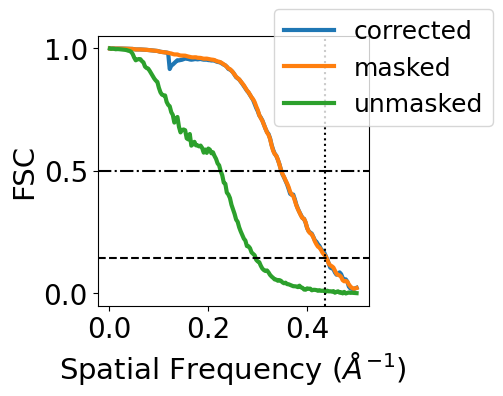

In [4]:
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation"
figures_dir = os.path.join(project_dir, "figures")
job = "job040"
fsc_postprocess_filename = os.path.join(project_dir, "PostProcess", job, "postprocess.star")
resolution = 2.29


fsc_cif = cif.read(fsc_postprocess_filename).find_block("fsc")
rlnResolution = fsc_cif.find_loop("_rlnResolution")
rlnFourierShellCorrelationCorrected = fsc_cif.find_loop("_rlnFourierShellCorrelationCorrected")
rlnFourierShellCorrelationParticleMaskFraction = fsc_cif.find_loop("_rlnFourierShellCorrelationParticleMaskFraction")
rlnFourierShellCorrelationUnmaskedMaps = fsc_cif.find_loop("_rlnFourierShellCorrelationUnmaskedMaps")
rlnFourierShellCorrelationMaskedMaps = fsc_cif.find_loop("_rlnFourierShellCorrelationMaskedMaps")
rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps = fsc_cif.find_loop("_rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps")

df = pd.DataFrame({
    "resolution": rlnResolution,
    "fsc": rlnFourierShellCorrelationCorrected,
    "fsc_masked": rlnFourierShellCorrelationMaskedMaps,
    "fsc_unmasked": rlnFourierShellCorrelationUnmaskedMaps,
    "fsc_masked_random": rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps,
    "fsc_masked_fraction": rlnFourierShellCorrelationParticleMaskFraction,
})

# convert all columns to float
for column in df.columns:
    df[column] = df[column].astype(float)

fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.lineplot(x="resolution", y="fsc", data=df, ax=ax, legend=True, label="corrected", linewidth=3)
sns.lineplot(x="resolution", y="fsc_masked", data=df, ax=ax, legend=True, label="masked", linewidth=3)
sns.lineplot(x="resolution", y="fsc_unmasked", data=df, ax=ax, legend=True, label="unmasked", linewidth=3)
ax.axhline(0.143, color="black", linestyle="--")
ax.axhline(0.5, color="black", linestyle="-.")
ax.axvline(1/resolution, color="black", linestyle="dotted")
ax.set_xlabel("Spatial Frequency ($\AA^{-1}$)", fontsize=21)
ax.set_ylabel("FSC", fontsize=21)
# ax.set_ylim((-0.1, 1.25))
# change the fontsize of the ticks and the legend
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=18, bbox_to_anchor=(0.65, 1.1), loc=2, borderaxespad=0.)

# fig.savefig(os.path.join(figures_dir, f"{job}_FSC.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(figures_dir, f'{job}_FSC.pdf')}")


## panel B
ResLog plot for single-conformation data set


B-factor masked: 17.77854567793456
saved figure to: /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation/figures/ResLog.pdf


/tmp/ipykernel_1479/1947829536.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


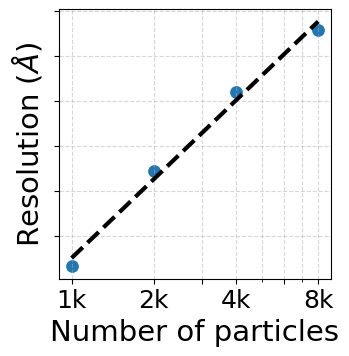

In [5]:
# data for single conformation set
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation"
data = {
    # 0: {
    #     "Nparticles": 250,
    #     "Select": "job033",
    #     "Refine3D": "job034",
    #     "MaskCreate": "job035",
    #     "PostProcess": "job036",
    # },
    # 1: {
    #     "Nparticles": 500,
    #     "Select": "job029",
    #     "Refine3D": "job030",
    #     "MaskCreate": "job031",
    #     "PostProcess": "job032",
    # },
    2: {
        "Nparticles": 1000,
        "Select": "job025",
        "Refine3D": "job026",
        "MaskCreate": "job027",
        "PostProcess": "job028",
    },
    3: {
        "Nparticles": 2000,
        "Select": "job021",
        "Refine3D": "job022",
        "MaskCreate": "job023",
        "PostProcess": "job024",
    },
    4: {
        "Nparticles": 4000,
        "Select": "job017",
        "Refine3D": "job018",
        "MaskCreate": "job019",
        "PostProcess": "job020",
    },
    5: {
        "Nparticles": 8000,
        "Select": "job037",
        "Refine3D": "job038",
        "MaskCreate": "job039",
        "PostProcess": "job040",
    },
}
# load the logfiles and retrieve the resolutions
results = get_resolution_from_logs(project_dir, data)
results_df = pd.DataFrame(results)
# add column for 1/res^2
results_df["1/res2"] = 1/results_df["res"]**2
results_df["1/res_unmasked2"] = 1/results_df["res_unmasked"]**2
    
# plot the results
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.scatterplot(
    data=results_df, x="Nparticles", y="res", ax=ax, s=100,
)
p = np.polyfit(np.log10(results_df["Nparticles"]), results_df["res"], 1)
y = np.polyval(p, np.log10(results_df["Nparticles"]))
ax.plot(results_df["Nparticles"], y, color="black", linestyle="--", linewidth=3)
# compute B-factor as 2X slope
p = np.polyfit(np.log10(results_df["Nparticles"]), results_df["1/res2"], 1)
B_factor = 2/p[0]
print(f"B-factor masked: {B_factor}")

ax.set_xlabel("Number of particles", fontsize=21)
ax.set_ylabel("Resolution ($\AA$)", fontsize=21)
ax.grid(axis="both", which="both", alpha=0.5, linestyle="--")
# invert x-axis
ax.invert_yaxis()

ax.set_xscale("log")
ax.set_xticks([1000, 2000, 3000, 4000, 6000, 8000])
ax.set_xticklabels(["1k", "2k", "", "4k", "", "8k"], fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

# fig.savefig(os.path.join(project_dir, "figures", "ResLog.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(project_dir, 'figures', 'ResLog.pdf')}")


## panel C
2D classes for the heterogeneous data set
FSC curve for the heterogeneous data set

saved figure to: /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/figures/class_averages.pdf


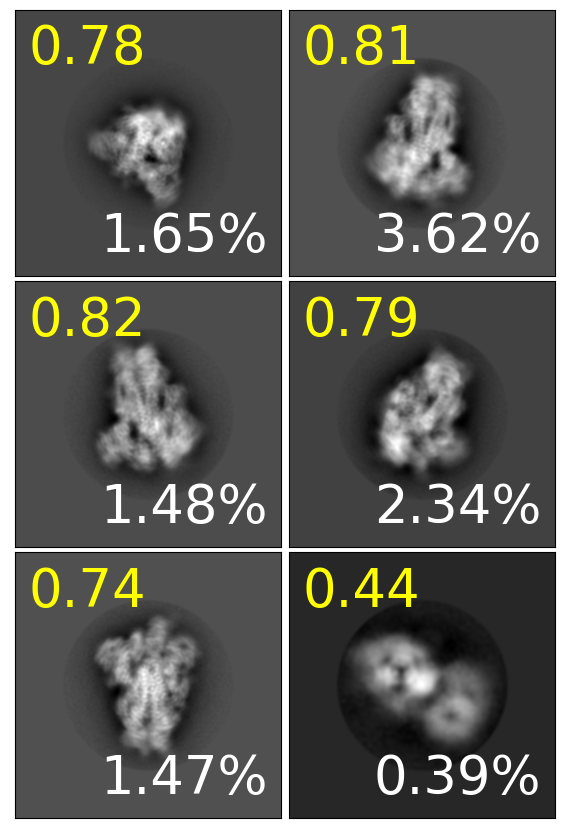

In [6]:
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA"
figures_dir = os.path.join(project_dir, "figures")
class_averages = os.path.join(project_dir, "Class2D", "job058", "run_it025_classes.mrcs")
ranker_output_file = os.path.join(project_dir, "Select", "job060", "class_averages.star")

num_rows = 3
num_columns = 2


class_averages_mrc = mrcfile.open(class_averages, mode='r')
class_ranker_cif = cif.read_file(ranker_output_file)
class_ranker_results = class_ranker_cif.sole_block()
rlnReferenceImage = class_ranker_results.find_loop('_rlnReferenceImage')
rlnPredictedClassScore = class_ranker_results.find_loop('_rlnPredictedClassScore')
rlnClassDistribution = class_ranker_results.find_loop('_rlnClassDistribution')
df = pd.DataFrame(data=[rlnReferenceImage, rlnPredictedClassScore, rlnClassDistribution], index=['rlnReferenceImage', 'rlnPredictedClassScore', 'rlnClassDistribution']).T
df["rlnPredictedClassScore"] = pd.to_numeric(df["rlnPredictedClassScore"])
df["rlnClassDistribution"] = pd.to_numeric(df["rlnClassDistribution"])
df["class_nr"] = df["rlnReferenceImage"].apply(lambda x: int(x.split('@')[0]))

fig, ax = plt.subplots(num_rows, num_columns, figsize=(3.5*num_columns, 3.5*num_rows))
for i, row in df.iterrows():
    if i >= num_rows * num_columns:
        break
    i_row = i // num_columns
    i_col = i % num_columns

    class_nr = row['class_nr']
    ax[i_row, i_col].imshow(class_averages_mrc.data[class_nr-1], cmap='gray', origin='upper')
    ax[i_row, i_col].set_xticks([])
    ax[i_row, i_col].set_yticks([])
    # ax[i_row, i_col].set_title('Class {}'.format(class_nr))
    # plot the predicted score as yellow text in the top left corner of the image
    ax[i_row, i_col].text(0.05, 0.95, '{:.2f}'.format(df['rlnPredictedClassScore'][i]), color='yellow', transform=ax[i_row, i_col].transAxes, fontsize=38, verticalalignment='top')
    # plot the fraction of particles in the class as white text in the bottom right corner of the image
    ax[i_row, i_col].text(0.95, 0.05, '{:.2f}%'.format(df['rlnClassDistribution'][i]*100), color='white', transform=ax[i_row, i_col].transAxes, fontsize=38, verticalalignment='bottom', horizontalalignment='right')
# remove spacing between subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)

# fig.savefig(os.path.join(figures_dir, "class_averages.pdf"), bbox_inches='tight')
print(f"saved figure to: {os.path.join(figures_dir, 'class_averages.pdf')}")


saved figure to: /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/figures/job016_FSC.pdf


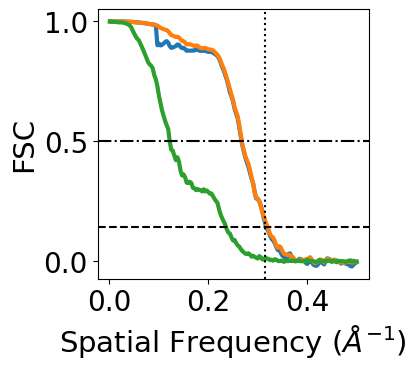

In [7]:
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA"
figures_dir = os.path.join(project_dir, "figures")
job = "job016"
fsc_postprocess_filename = os.path.join(project_dir, "PostProcess", job, "postprocess.star")
figures_dir = os.path.join(project_dir, "figures")
resolution = 3.17

fsc_cif = cif.read(fsc_postprocess_filename).find_block("fsc")
rlnResolution = fsc_cif.find_loop("_rlnResolution")
rlnFourierShellCorrelationCorrected = fsc_cif.find_loop("_rlnFourierShellCorrelationCorrected")
rlnFourierShellCorrelationParticleMaskFraction = fsc_cif.find_loop("_rlnFourierShellCorrelationParticleMaskFraction")
rlnFourierShellCorrelationUnmaskedMaps = fsc_cif.find_loop("_rlnFourierShellCorrelationUnmaskedMaps")
rlnFourierShellCorrelationMaskedMaps = fsc_cif.find_loop("_rlnFourierShellCorrelationMaskedMaps")
rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps = fsc_cif.find_loop("_rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps")

df = pd.DataFrame({
    "resolution": rlnResolution,
    "fsc": rlnFourierShellCorrelationCorrected,
    "fsc_masked": rlnFourierShellCorrelationMaskedMaps,
    "fsc_unmasked": rlnFourierShellCorrelationUnmaskedMaps,
    "fsc_masked_random": rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps,
    "fsc_masked_fraction": rlnFourierShellCorrelationParticleMaskFraction,
})

# convert all columns to float
for column in df.columns:
    df[column] = df[column].astype(float)

fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.lineplot(x="resolution", y="fsc", data=df, ax=ax, legend=True, label="corrected", linewidth=3)
sns.lineplot(x="resolution", y="fsc_masked", data=df, ax=ax, legend=True, label="masked", linewidth=3)
sns.lineplot(x="resolution", y="fsc_unmasked", data=df, ax=ax, legend=True, label="unmasked", linewidth=3)
ax.axhline(0.143, color="black", linestyle="--")
ax.axhline(0.5, color="black", linestyle="-.")
ax.axvline(1/resolution, color="black", linestyle="dotted")
ax.set_xlabel("Spatial Frequency ($\AA^{-1}$)", fontsize=21)
ax.set_ylabel("FSC", fontsize=21)
# ax.set_ylim((-0.1, 1.25))
# change the fontsize of the ticks and the legend
ax.tick_params(axis='both', which='major', labelsize=20)
# ax.legend(fontsize=18, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.legend().remove()

# fig.savefig(os.path.join(figures_dir, f"{job}_FSC.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(figures_dir, f'{job}_FSC.pdf')}")

## panel D
ResLog plot for the heterogeneous data set

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


B-factor masked: 41.09042363473794
saved figure to: /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/figures/ResLog.pdf


/tmp/ipykernel_1479/704394723.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


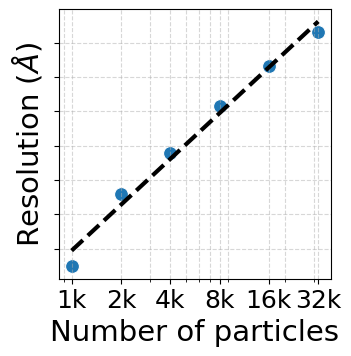

In [8]:
# data for full MD trajectory
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA"
figures_dir = os.path.join(project_dir, "figures")
data = {
    # 0: {
    #     "Nparticles": 250,
    #     "Select": "job033",
    #     "Refine3D": "job034",
    #     "MaskCreate": "job035",
    #     "PostProcess": "job036",
    # },
    # 1: {
    #     "Nparticles": 500,
    #     "Select": "job029",
    #     "Refine3D": "job030",
    #     "MaskCreate": "job031",
    #     "PostProcess": "job032",
    # },
    2: {
        "Nparticles": 1000,
        "Select": "job025",
        "Refine3D": "job026",
        "MaskCreate": "job027",
        "PostProcess": "job028",
    },
    3: {
        "Nparticles": 2000,
        "Select": "job021",
        "Refine3D": "job022",
        "MaskCreate": "job023",
        "PostProcess": "job024",
    },
    4: {
        "Nparticles": 4000,
        "Select": "job017",
        "Refine3D": "job018",
        "MaskCreate": "job019",
        "PostProcess": "job020",
    },
    5: {
        "Nparticles": 8000,
        "Select": "job006",
        "Refine3D": "job014",
        "MaskCreate": "job015",
        "PostProcess": "job016",
    },
    6: {
        "Nparticles": 16000,
        "Select": "job050",
        "Refine3D": "job051",
        "MaskCreate": "job054",
        "PostProcess": "job055",
    },
    7: {
        "Nparticles": 32000,
        "Select": "job052",
        "Refine3D": "job053",
        "MaskCreate": "job056",
        "PostProcess": "job057",
    },
}
# load the logfiles and retrieve the resolutions
results = get_resolution_from_logs(project_dir, data, False)
results_df = pd.DataFrame(results)
# add column for 1/res^2
results_df["1/res2"] = 1/results_df["res"]**2
results_df["1/res_unmasked2"] = 1/results_df["res_unmasked"]**2
    
# plot the results
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.scatterplot(
    data=results_df, x="Nparticles", y="res", ax=ax, s=100,
)
p = np.polyfit(np.log10(results_df["Nparticles"]), results_df["res"], 1)
y = np.polyval(p, np.log10(results_df["Nparticles"]))
ax.plot(results_df["Nparticles"], y, color="black", linestyle="--", linewidth=3)
# compute B-factor as 2X slope
p = np.polyfit(np.log10(results_df["Nparticles"]), results_df["1/res2"], 1)
B_factor = 2/p[0]
print(f"B-factor masked: {B_factor}")

ax.set_xlabel("Number of particles", fontsize=21)
ax.set_ylabel("Resolution ($\AA$)", fontsize=21)
ax.grid(axis="both", which="both", alpha=0.5, linestyle="--")
# invert x-axis
ax.invert_yaxis()
ax.legend().remove()

ax.set_xscale("log")
ax.set_xticks([1000, 2000, 4000, 8000, 16000, 32000])
ax.set_xticklabels(["1k", "2k", "4k", "8k", "16k", "32k"], fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

# fig.savefig(os.path.join(figures_dir, "ResLog.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(figures_dir, 'ResLog.pdf')}")


## panel E
plot of the resolution dependence on the number of frames of the MD trajectory that are included in the particles. The total number of particles remains constant at 4000

saved figure to: /home/mjoosten1/projects/roodmus/data/20240102_limited_K_dataset/figures/resolution_Bfactor_vs_K.pdf


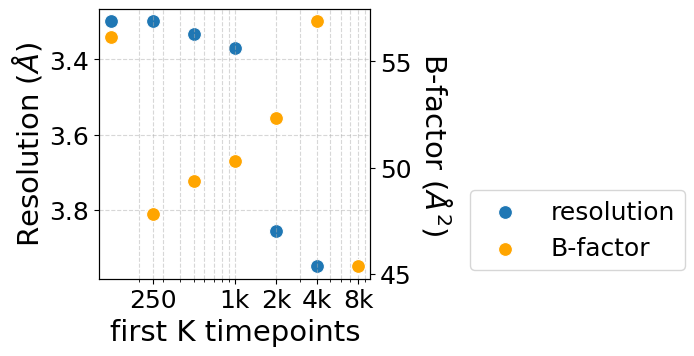

In [9]:
# define jobs to use
project_dir = "/home/mjoosten1/projects/roodmus/data/20240102_limited_K_dataset"
figures_dir = os.path.join(project_dir, "figures")

data = {
    0: {
        "K": 125,
        "Nparticles": 4000,
        "Import": "job007",
        "Refine3D": "job009",
        "MaskCreate": "job010",
        "PostProcess": "job011",
    },
    1: {
        "K": 8000,
        "Nparticles": 4000,
        "Import": "job012",
        "Refine3D": "job014",
        "MaskCreate": "job015",
        "PostProcess": "job016",
    },
    2: {
        "K": 250,
        "Nparticles": 4000,
        "Import": "job017",
        "Refine3D": "job019",
        "MaskCreate": "job020",
        "PostProcess": "job021",
    },
    3: {
        "K": 500,
        "Nparticles": 4000,
        "Import": "job022",
        "Refine3D": "job024",
        "MaskCreate": "job025",
        "PostProcess": "job026",
    },
    4: {
        "K": 1000,
        "Nparticles": 4000,
        "Import": "job027",
        "Refine3D": "job029",
        "MaskCreate": "job030",
        "PostProcess": "job031",
    },
    5: {
        "K": 2000,
        "Nparticles": 4000,
        "Import": "job032",
        "Refine3D": "job034",
        "MaskCreate": "job035",
        "PostProcess": "job036",
    },
    6: {
        "K": 4000,
        "Nparticles": 4000,
        "Import": "job037",
        "Refine3D": "job039",
        "MaskCreate": "job040",
        "PostProcess": "job041",
    },
}

results = {
    "K": [],
    "Nparticles": [],
    "res_unmasked": [],
    "res": [],
    "B_fac": [],
}

# loop over the jobs and get the resolution and B-factor from the log files
for _, item in data.items():
    Refine3D_log = os.path.join(project_dir, "Refine3D", item["Refine3D"], "run.out")
    pattern = r"Auto-refine: \+ Final resolution \(without masking\) is: (\d+\.\d+)"
    with open(Refine3D_log, "r") as f:
        for line in f.readlines():
            if re.search(pattern, line):
                res_unmasked = float(re.search(pattern, line).group(1))
                break

    PostProcess_log = os.path.join(project_dir, "PostProcess", item["PostProcess"], "run.out")
    pattern = r"\+\s*FINAL\s+RESOLUTION:\s+(\d+(\.\d+)?)"
    with open(PostProcess_log, "r") as f:
        for line in f.readlines():
            if re.search(pattern, line):
                res = float(re.search(pattern, line).group(1))
                break
    
    pattern = r"\+\s*apply\s+b-factor\s+of:\s+(-?\d+(\.\d+)?)"
    with open(PostProcess_log, "r") as f:
        for line in f.readlines():
            if re.search(pattern, line):
                B_fac = float(re.search(pattern, line).group(1))
                break

    results["K"].append(item["K"])
    results["Nparticles"].append(item["Nparticles"])
    results["res_unmasked"].append(res_unmasked)
    results["res"].append(res)
    results["B_fac"].append(-B_fac)
    # results["localres_std"].append(localres_std)

results_df = pd.DataFrame(results)
    
# plot the results
fig, ax_res = plt.subplots(figsize=(3.5, 3.5))
ax_Bfac = ax_res.twinx()
sns.scatterplot(
    data=results_df, x="K", y="res", ax=ax_res, label="resolution", s=100,
)
sns.scatterplot(
    data=results_df, x="K", y="B_fac", ax=ax_Bfac, label="B-factor", color="orange", s=100,
)
ax_res.set_xlabel("first K timepoints", fontsize=21)
ax_res.set_ylabel("Resolution ($\AA$)", fontsize=21)
ax_res.set_xscale("log")
ax_res.grid(axis="both", which="both", alpha=0.5, linestyle="--")
# ax_res.set_ylim((3.0, 4.1))
ax_res.invert_yaxis()
ax_Bfac.set_ylabel("B-factor ($\AA^2$)", fontsize=21, rotation=270, labelpad=30)
# ax_Bfac.set_ylim((40, 65))
# remove legends from the axis and add a single legend
ax_res.get_legend().remove()
ax_Bfac.get_legend().remove()
fig.legend(loc="upper left", bbox_to_anchor=(1.15, 0.40), ncol=1, fontsize=18)

# ax_Bfac.set_yticklabels(ax_Bfac.get_yticklabels(), fontsize=18)
# ax_res.set_yticklabels(ax_res.get_yticklabels(), fontsize=18)
ax_Bfac.tick_params(axis='y', labelsize=18)
ax_res.tick_params(axis='y', labelsize=18)
ax_res.set_xticks([250, 1000, 2000, 4000, 8000])
ax_res.set_xticklabels(["250", "1k", "2k", "4k", "8k"], fontsize=18)

# fig.savefig(os.path.join(figures_dir, "resolution_Bfactor_vs_K.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(figures_dir, 'resolution_Bfactor_vs_K.pdf')}")


## panel F
plot of the particle picking precision and recall throughout the processing of the heterogeneous data set

In [10]:
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA"
# project_dir = "/mnt/ceph/JGreer/MapReconstruction/DESRES-Trajectory_sarscov2-11021571-all-glueCA"
# project_dir = "/home/dvi41342/MapReconstruction/DESRES-Trajectory_sarscov2-11021571-all-glueCA_subset"
config_dir = os.path.join(project_dir, "Micrographs")
figures_dir = os.path.join(project_dir, "figures")
meta_files = [
    os.path.join(project_dir, "Extract", "job007", "particles.star"),
    os.path.join(project_dir, "Class2D", "job008", "run_it200_data.star"),
    os.path.join(project_dir, "Select", "job009", "particles.star"),
    os.path.join(project_dir, "Select", "job036", "particles.star"),
    os.path.join(project_dir, "Select", "job037", "particles.star"),
    os.path.join(project_dir, "Select", "job038", "particles.star"),
    os.path.join(project_dir, "Select", "job039", "particles.star"),
    # os.path.join(project_dir, "Refine3D", "job014", "run_it015_data.star"),
    # os.path.join(project_dir, "Refine3D", "job020", "run_it017_data.star"),
    # os.path.join(project_dir, "Refine3D", "job008", "run_it011_data.star"),
]

jobtypes = {
    os.path.join(project_dir, "Extract", "job007", "particles.star"): "topaz picker",
    os.path.join(project_dir, "Class2D", "job008", "run_it200_data.star"): "2D classification",
    os.path.join(project_dir, "Select", "job009", "particles.star"): "2D class selection",
    os.path.join(project_dir, "Select", "job036", "particles.star"): "3D class 0",
    os.path.join(project_dir, "Select", "job037", "particles.star"): "3D class 1",
    os.path.join(project_dir, "Select", "job038", "particles.star"): "3D class 2",
    os.path.join(project_dir, "Select", "job039", "particles.star"): "3D class 3",
    os.path.join(project_dir, "Refine3D", "job014", "run_it015_data.star"): "Homogeneous refinement 1",
    os.path.join(project_dir, "Refine3D", "job020", "run_it017_data.star"): "Homogeneous refinement 2",
    os.path.join(project_dir, "Refine3D", "job008", "run_it011_data.star"): "Homogeneous refinement 3",
}

particle_diameter = 100 # approximate particle diameter in Angstroms
ugraph_shape = (4000, 4000) # shape of the micrograph in pixels. Only needs to be given if the metadata file is a .star file
verbose = True # prints out progress statements
ignore_missing_files = True # if .mrc files are missing, the analysis will still be performed
enable_tqdm = True # enables tqdm progress bars

for i, meta_file in enumerate(meta_files):
    if i == 0:
        analysis = load_data(meta_file, config_dir, particle_diameter, ugraph_shape=ugraph_shape, verbose=verbose, enable_tqdm=enable_tqdm, ignore_missing_files=ignore_missing_files) # creates the class
    else:
        analysis.add_data(meta_file, config_dir, verbose=verbose) # updates the class with the next metadata file
    
df_picked = pd.DataFrame(analysis.results_picking)
df_truth = pd.DataFrame(analysis.results_truth)
# df_precision, df_picked = analysis.compute_precision(df_picked, df_truth, verbose=verbose)
# print(f"mean precision: {df_precision['precision'].mean()}")
# print(f"mean recall: {df_precision['recall'].mean()}")

p_match, _, p_unmatched, t_unmatched = analysis._match_particles(
    meta_files,
    df_picked,
    df_truth,
    verbose=False,
    enable_tqdm=True,
)
df_precision = analysis.compute_1to1_match_precision(
    p_match,
    p_unmatched,
    t_unmatched,
    df_truth,
    verbose=False,
)
df_precision.head()

loading metadata from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Extract/job007/particles.star...
loaded metadata from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Extract/job007/particles.star. determined file type: star


Dictionaries now contain 240974 reconstructed particles
added 240974 particles from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Extract/job007/particles.star


loading truth data:  15%|█▍        | 134/900 [01:03<06:12,  2.06it/s, micrograph=000133.mrc]

loading truth data: 100%|█████████▉| 899/900 [10:40<00:00,  1.40it/s, micrograph=000899.mrc]


Loaded ground-truth particle positions from config files
Dictionaries now contain 240974 particles and 269700 true particles
Added 269700 particles from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Micrographs
loading metadata from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Class2D/job008/run_it200_data.star...
loaded metadata from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Class2D/job008/run_it200_data.star. determined file type: star
checking if ugraphs exist...


Dictionaries now contain 481948 reconstructed particles
added 240974 particles from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Class2D/job008/run_it200_data.star
loading metadata from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/D

computing closest matches: 100%|██████████| 900/900 [00:24<00:00, 36.64it/s]


For each micrograph, for each metadata file, compute the precision, recall and multiplicity
Speed of computation depends on the number of particles in the micrograph. progressbar is not accurate


computing precision: 6293it [00:12, 519.35it/s, precision=1, recall=0.19, multiplicity=0]                             


,metadata_filename,ugraph_filename,defocus,num_particles_picked,num_particles_truth,TP,FP,FN,precision,recall,multiplicity
0,/home/mjoosten1/projects/roodmus/data/DE-Shaw_...,000000.mrc,-15309.734341,269,300,269,0,1038,1.000000,0.896667,0
1,/home/mjoosten1/projects/roodmus/data/DE-Shaw_...,000001.mrc,-26247.911555,263,300,263,0,1048,1.000000,0.876667,0
2,/home/mjoosten1/projects/roodmus/data/DE-Shaw_...,000002.mrc,-24737.877217,266,300,266,0,1040,1.000000,0.886667,0
3,/home/mjoosten1/projects/roodmus/data/DE-Shaw_...,000003.mrc,-20228.908035,268,300,267,1,1034,0.996269,0.890000,0
4,/home/mjoosten1/projects/roodmus/data/DE-Shaw_...,000004.mrc,-17079.156566,275,300,272,3,1020,0.989091,0.906667,0


/tmp/ipykernel_1479/1610321574.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


saved figure to: /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/figures/precision.pdf


/tmp/ipykernel_1479/1610321574.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


saved figure to: /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/figures/recall.pdf


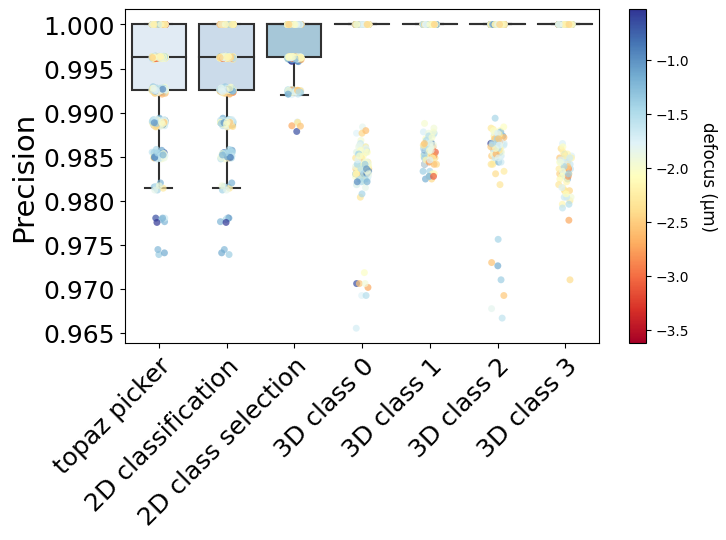

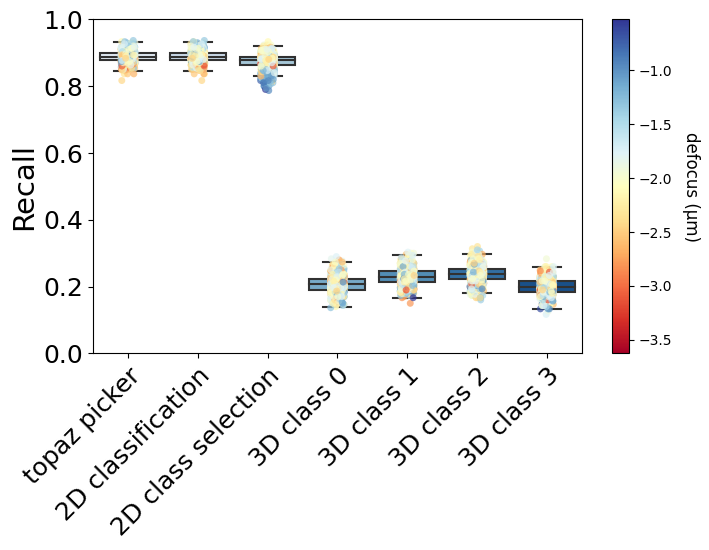

In [11]:
order = []
for r in meta_files:
    if type(r) == str:
        order.append(r)
    else:
        order.append(r[0])  
fig, ax = plot_precision(df_precision, jobtypes, order)
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, fontsize=12)
ax.set_title("")
fig.set_size_inches(7, 7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_ylabel("Precision", fontsize=21)

fig.savefig(os.path.join(figures_dir, "precision.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(figures_dir, 'precision.pdf')}")

fig, ax = plot_recall(df_precision, jobtypes, order)
ax.set_ylim((0,1))
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, fontsize=12)
ax.set_title("")
fig.set_size_inches(7, 7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_ylabel("Recall", fontsize=21)

fig.savefig(os.path.join(figures_dir, "recall.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(figures_dir, 'recall.pdf')}")


In [12]:
# print the precision and recall for the topaz picking job
df_precision["jobtype"] = df_precision["metadata_filename"].apply(lambda x: jobtypes[x])
df_picked["jobtype"] = df_picked["metadata_filename"].apply(lambda x: jobtypes[x])
p_match["jobtype"] = p_match["metadata_filename"].apply(lambda x: jobtypes[x])
print(f"unique jobs: {df_precision['jobtype'].unique()}")

print(f"mean precision for topaz picking: {df_precision[df_precision['jobtype'] == 'topaz picker']['precision'].mean()}")
print(f"mean recall for topaz picking: {df_precision[df_precision['jobtype'] == 'topaz picker']['recall'].mean()}")
print(f"min recall for topaz picking: {df_precision[df_precision['jobtype'] == 'topaz picker']['recall'].min()}")
print(f"max recall for topaz picking: {df_precision[df_precision['jobtype'] == 'topaz picker']['recall'].max()}")

print(f"total number of particles for topaz picking job: {len(df_picked[df_picked['jobtype'] == 'topaz picker'])}")
print(f"total number of TP particles picked during topaz picking job: {len(p_match[p_match['jobtype'] == 'topaz picker'])}")
print(f"total number of GT particles in the dataset: {len(df_truth)}")
print(f"fraction of GT particles picked during topaz picking job: {len(p_match[p_match['jobtype'] == 'topaz picker'])/len(df_truth)}")


unique jobs: ['2D classification' 'topaz picker' '2D class selection' '3D class 0'
 '3D class 1' '3D class 2' '3D class 3']
mean precision for topaz picking: 0.9952810621747252
mean recall for topaz picking: 0.8882499073044122
min recall for topaz picking: 0.8166666666666667
max recall for topaz picking: 0.9366666666666666
total number of particles for topaz picking job: 240974
total number of TP particles picked during topaz picking job: 239561
total number of GT particles in the dataset: 269700
fraction of GT particles picked during topaz picking job: 0.8882499073044123


# in text
Compare the local resolution maps for the single-conformation dataset and the conformationally heterogeneous data by masking the LocRes maps and computing the variance in resolution over the map.

mean single conformation: 2.1778156757354736
mean conformationally heterogeneous: 3.0301895141601562
variance single conformation: 0.6089126467704773
variance conformationally heterogeneous: 1.1291253566741943
min single conformation: 0.018280357122421265
min conformationally heterogeneous: 0.024605803191661835
max single conformation: 4.764578819274902
max conformationally heterogeneous: 5.988613605499268


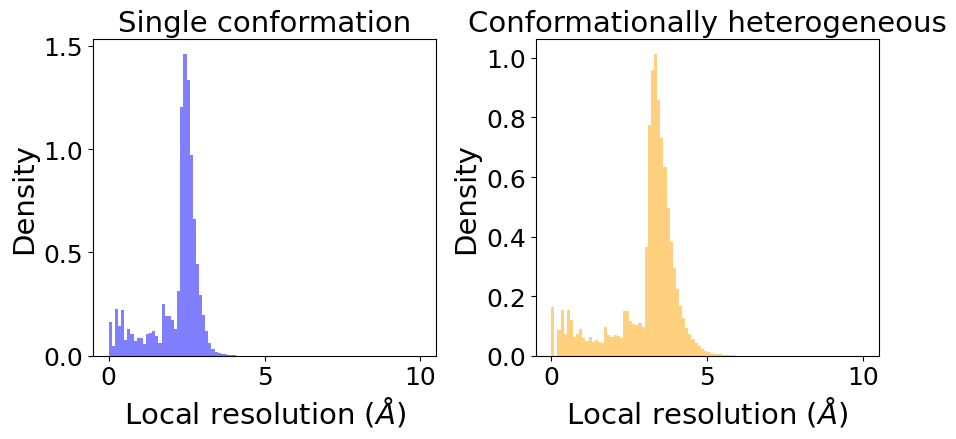

In [13]:
# single-conformation dataset
locres_sc_file = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation/LocalRes/job041/relion_locres.mrc"
mask_sc_file = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation/MaskCreate/job039/mask.mrc"

# conformationally heterogeneous dataset
locres_ht_file = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/LocalRes/job037/relion_locres.mrc"
mask_ht_file = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/MaskCreate/job015/mask.mrc"

# load the mrc files
locres_sc = mrcfile.open(locres_sc_file, mode='r')
mask_sc = mrcfile.open(mask_sc_file, mode='r')
locres_sc_data = locres_sc.data * mask_sc.data
locres_sc_data[locres_sc_data == 0] = np.nan
locres_ht = mrcfile.open(locres_ht_file, mode='r')
mask_ht = mrcfile.open(mask_ht_file, mode='r')
locres_ht_data = locres_ht.data * mask_ht.data
locres_ht_data[locres_ht_data == 0] = np.nan

# plot the local resolution
fig, ax = plt.subplots(1, 2, figsize=(4.5*2, 4.5))
ax[0].hist(locres_sc_data.flatten(), bins=100, range=(0, 10), density=True, color="blue", alpha=0.5);
ax[0].set_xlabel("Local resolution ($\AA$)", fontsize=21)
ax[0].set_ylabel("Density", fontsize=21)
ax[0].set_title("Single conformation", fontsize=21)
ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[1].hist(locres_ht_data.flatten(), bins=100, range=(0, 10), density=True, color="orange", alpha=0.5);
ax[1].set_xlabel("Local resolution ($\AA$)", fontsize=21)
ax[1].set_ylabel("Density", fontsize=21)
ax[1].set_title("Conformationally heterogeneous", fontsize=21)
ax[1].tick_params(axis='both', which='major', labelsize=18)
fig.tight_layout()

# print the mean and variance of the local resolution
print(f"mean single conformation: {np.nanmean(locres_sc_data)}")
print(f"mean conformationally heterogeneous: {np.nanmean(locres_ht_data)}")
print(f"variance single conformation: {np.nanvar(locres_sc_data)}")
print(f"variance conformationally heterogeneous: {np.nanvar(locres_ht_data)}")
print(f"min single conformation: {np.nanmin(locres_sc_data)}")
print(f"min conformationally heterogeneous: {np.nanmin(locres_ht_data)}")
print(f"max single conformation: {np.nanmax(locres_sc_data)}")
print(f"max conformationally heterogeneous: {np.nanmax(locres_ht_data)}")
